# TinyGPT

**Author: Abraham R.**

The following notebook is an example of a really tiny GPT based model called TinyGPT.
You'll review the GPT architecture (transformer decoder) and implement the following tasks:

## TinyGPT Architecture

Tailored for the [NLP-II course](https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/CEIA-LLMIAG) as we deal with architectures and theory, this model consists of a **Mixture of Experts GPT**, equivalent to models like:
- DeepSeek
- Mistral

## Tasks

Using TinyGPT you need to implement the following modifications:


## Inference: Modify the generate function to:
- Greedy decoding (pick max probability token).
- Temperature sampling.
- top-k or top-p sampling.

### References
- [huggingface generate](https://huggingface.co/docs/transformers/main_classes/text_generation)

## Architecture:
- Make TinyGPT a Mixture of Experts (MoE) of at least 2 experts.

## What to expect?

- You'll manage to understand a depth implementation of a GPT model.
- Implement a MoE Layer to create a state-of-the art GPT model.
- Explore decoding algorithms for text generation.


### NOTE

Tokenization is out of scope, we'll use a simple yet ineffective character-based tokenizer.


In [64]:
#from google.colab import drive
#drive.mount('/content/drive')

#%cd /content/drive/MyDrive/PLN_II
#!ls

# COMPATIBILIDAD NVIDIA GTX-970
import torch._dynamo
torch._dynamo.config.suppress_errors = True

In [65]:
import torch
from torch import nn
import torch.nn.functional as F
from dataclasses import dataclass, field
from typing import Optional, List, Type
import httpx

from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

from trainer import Trainer
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR


## Downloading Dataset

In [66]:
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
#url = "https://www.gutenberg.org/cache/epub/64317/pg64317.txt" # The Great Gatsby

response = httpx.get(url)
text = response.text

text = text[:120_000]  # Using 100k characters for speedup FEDE
print(text)

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



# Character-based encoding

In [67]:
chars = sorted(list(set(text))) # Toma el texto y obtiene los caracteres que lo conforman, luego genera una lista ordenada alfabeticamente.
vocab_size = len(chars) # Tamaño del vocabulario (Numero de caracteres)
stoi = {ch: i for i, ch in enumerate(chars)} # Genera diccionario para la conversion de string a enteros
itos = {i: ch for ch, i in stoi.items()} # Genera diccionario para la conversion de enteros a string
def encode(s): return [stoi[c] for c in s] #Define funcion para codificar caracteres
def decode(l): return ''.join([itos[i] for i in l])#Define uncion poara decodificar caracteres
data = torch.tensor(encode(text), dtype=torch.long) #Convierte el texto a secuencia de numeros como tensor

# Train/test split
split = int(0.9 * len(data)) # separa datos en 90 y 10%
train_data = data[:split] #90% de datos para entrenamiento
val_data = data[split:]

# Dataloaders

In [68]:
#Define clase que recibe cadena de caracteres (input) y un tamaño de bloque (Ventana), y retorna el par X,Y siendo las cadenas definidas por el largo del bloque y la
#  misma cadena desplazada en una posicion. Se va desplazando la ventana por el texto de a un caracter.

class CharDataset(Dataset):
    def __init__(self, data: torch.Tensor, block_size: int):
        self.data = data
        self.block_size = block_size

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.block_size]
        y = self.data[idx + 1 : idx + self.block_size + 1]
        return x, y

# GPT Configuration

In [69]:
@dataclass
class MoEArgs():
    """
    MoE input arguments class.
    """
    num_experts : int = field(default=4)
    num_experts_per_token : int = field(default=2)
    top_k : int = field(default=2) # FEDERICO

@dataclass
class GPTConfig:
    """
    Base class for GPT models.
    """
    block_size: int = 32
    batch_size: int = 8
    n_embd: int = 64
    #n_head: int = 4
    n_head: int = 8
    n_layer: int = 2
    dropout: float = 0.1
    vocab_size: int = vocab_size
    bias: bool = True
    ff_class: Optional[Type[nn.Module]] = None
    moe_args : Optional[MoEArgs] = None

config = GPTConfig()
print(config.__dict__)

{'block_size': 32, 'batch_size': 8, 'n_embd': 64, 'n_head': 8, 'n_layer': 2, 'dropout': 0.1, 'vocab_size': 61, 'bias': True, 'ff_class': None, 'moe_args': None}


In [70]:
train_dataset = CharDataset(train_data, config.block_size) #Se instancia clase con datos de entrenamiento de tamaño block_size
val_dataset = CharDataset(val_data, config.block_size) #Se instancia clase con datos de validacion

# Se generan los dataloaders correspondientes para train and val partiendo de los objetos XXX_dataset.
train_loader = DataLoader(train_dataset,
                        batch_size=config.batch_size,
                        shuffle=True,
                        drop_last=True,
                        pin_memory=True,
                        num_workers= 8, # if using mps set num_workers as 0.
                        )
val_loader = DataLoader(val_dataset,
                        batch_size=config.batch_size,
                        shuffle=False,
                        drop_last=True,
                        pin_memory=True,
                        num_workers= 8,
                        )

In [71]:
# clase que define una unica cabeza de atencion
class AttentionHead(nn.Module):
    """
    Scaled Dot-Product Attention Head for Multi-Head Attention.
    """
    def __init__(self, args: GPTConfig) -> None:
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head" # controles de consistencia de datos y parametros
        self.head_dim = args.n_embd // args.n_head #El espacio de embeddings es separado en partes guales hacia cada cabeza de atension, con lo cual se definen dimensiones de heads de manera consistente

        # Combined QKV projection
        self.key_query_value = nn.Linear(args.n_embd, 3 * self.head_dim, bias=args.bias) # Entrada dim del input embedding y salida 3 vectores QKV= inut embedding del self-attention head.

        self.dropout = nn.Dropout(args.dropout) #Aplico dropout solo en trainign
        self.block_size = args.block_size
        self.register_buffer('tril', torch.tril(torch.ones(args.block_size, args.block_size))) # Creo buffer con la Mask de atencion con matriz triangular inferior.

    # Cabeza de atención recibe input embedding y parametros kv_cache y return_weights
    def forward(self, x: torch.Tensor, kv_cache: Optional[torch.Tensor] = None, return_weights=False):
        B, T, C = x.shape #X corresponde al tensor con los datos del batch en proceso, bloque de caracteres de entrada y bloque de caracteres de salida (edsplazado 1 caracter)
        key_query_value = self.key_query_value(x)  # (B, T, 3 * head_dim) - Es decir paso el batch por la red FFN  obtengo los 3 vectores QKV
        k, q, v = torch.chunk(key_query_value, 3, dim=-1)  # (B, T, head_dim) each ENTONCES Los separo

        # Se van almacenando los vectores para los token que ya fueron procesados con el fin de hacer eficiente la generacion - En train suele ser None.
        if kv_cache is not None:
            key_cache, value_cache = kv_cache.unbind(dim=0)  # (B, T', head_dim)
            k = torch.cat((key_cache, k), dim=1)
            v = torch.cat((value_cache, v), dim=1)

        # Scaled dot-product attention
        wei = q @ k.transpose(-2, -1) * (self.head_dim ** -0.5)  # (B, T, T) Se aplica formula Q.K⁷/SQRT(d)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # Se le aplica la Mask de atencion- reemplaza 0 por -inf para la Softmax posterior
        wei = F.softmax(wei, dim=-1) #Al resultado se le aplica Softmax
        wei = self.dropout(wei) #Se aplica dropout a los pesos de atencion - Esto debe estudiarse mejor!!!!

        out = wei @ v  # (B, T, head_dim) Se multiplica por V para finalizar el calculo de la matriz de Atencion.

        if return_weights:
            return out, wei

        if kv_cache is not None:
            return out, torch.stack((k, v))

        return out, None

In [72]:
class MultiHeadAttention(nn.Module):
    def __init__(self, args: GPTConfig):
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.n_heads = args.n_head
        self.head_dim = args.n_embd // args.n_head

        self.heads = nn.ModuleList([ #Lista de modulos nn.Module
            AttentionHead(args) for _ in range(self.n_heads) # instancia las cabezas de atencion para que trabajen en paralelo
        ])

        self.proj = nn.Linear(args.n_embd, args.n_embd, bias=args.bias) # Capa lineal de poryeccion
        self.dropout = nn.Dropout(args.dropout) #Dropouts

    def forward(self, x, kv_cache=None, return_weights=False):
        all_outputs = []
        all_weights = []
        new_kv_cache = [] if kv_cache is not None else None

        for i, head in enumerate(self.heads): #por cada cabeza de atencion se procesan los datos de entrada
            head_cache = kv_cache[i] if kv_cache is not None else None
            out, weights_or_kv = head(x, kv_cache=head_cache, return_weights=return_weights)
            all_outputs.append(out)
            if return_weights:
                all_weights.append(weights_or_kv)
            if kv_cache is not None:
                new_kv_cache.append(weights_or_kv)  # weights_or_kv is new kv_cache here

        concat = torch.cat(all_outputs, dim=-1)  # concat along embedding dim - Concatena las salidas y pasa por capa lineal
        out = self.dropout(self.proj(concat))

        if return_weights:
            return out, torch.stack(all_weights)
        if kv_cache is not None:
            return out, new_kv_cache
        return out

In [73]:
class FeedForward(nn.Module): # Definicion de capa lineal FFN de entrada por token
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module): # Construye el bloque Transformer uniendo los componentes Lay&Norm - FFN - Multi-Head Attention Block
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd) #Se instancias los objetos que conforman el bloque transformer
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.attn = MultiHeadAttention(config)

        ff_class = config.ff_class if config.ff_class is not None else FeedForward
        self.ff = ff_class(config)

    def forward(self, x, kv_cache=None, return_weights=False):
        attn_out = self.attn(self.ln1(x), kv_cache=kv_cache, return_weights=return_weights) #Se iteran los datos de entrada por la primera capa L&N y se envia al bloque multihead
        if return_weights:
            attn_out, weights = attn_out
        else:
            weights = None

        if isinstance(attn_out, tuple):
            attn_out, updated_kv = attn_out
        else:
            updated_kv = None

        x = x + attn_out
        x = x + self.ff(self.ln2(x)) # se le suma la conexion residual y se pasa el resulado por capa FFN final
        return (x, updated_kv, weights) if return_weights else (x, updated_kv)

## TinyGPT Architecture

In [74]:
class TinyGPT(nn.Module): # Se define la clase de todo el modelo
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.token_emb = nn.Embedding(config.vocab_size, config.n_embd) #Embedding de inputs
        self.pos_emb = nn.Embedding(config.block_size, config.n_embd)#Embedding de Posicion
        self.blocks = nn.ModuleList([Block(config) for _ in range(config.n_layer)]) #Se instancias los N=n_layer = 2 bloques transformer
        self.ln_f = nn.LayerNorm(config.n_embd) #Capa de normalizacion
        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False) #Capa de salida
        self.config = config

    def forward(self, idx, kv_cache=None, return_weights=False): #Se procesa el token por su indice idx
        B, T = idx.shape # B: Batch size (número de secuencias/ejemplos procesados en paralelo). T: Longitud de la secuencia (número de tokens en cada secuencia).
                         # idx: contiene los índices de los tokens de entrada.
        tok_emb = self.token_emb(idx) # a partir de cada token genera su embedding correspondiente
        pos = torch.arange(T, device=idx.device)
        pos_emb = self.pos_emb(pos)[None, :, :] #Genera vector de embedding posicional
        x = tok_emb + pos_emb # Suma ambos embeddings para generar la entrada.

        new_kv_cache = [] if kv_cache is not None else None
        all_weights = [] if return_weights else None

        for i, block in enumerate(self.blocks): # Itera sobre los bloques que compoenen el modelo pasandole los datos de entrada
            layer_kv = kv_cache[i] if kv_cache is not None else None
            if return_weights:
                x, updated_kv, weights = block(x, kv_cache=layer_kv, return_weights=True)
                all_weights.append(weights)  # weights shape: (n_heads, B, T, T)
            else:
                x, updated_kv = block(x, kv_cache=layer_kv)
            if kv_cache is not None:
                new_kv_cache.append(updated_kv)

        x = self.ln_f(x)
        logits = self.head(x)

        if return_weights:
            if kv_cache is not None:
                return logits, new_kv_cache, all_weights
            else:
                return logits, all_weights
        else:
            if kv_cache is not None:
                return logits, new_kv_cache
            return logits


## Generation function (inference)

In [75]:
@torch.no_grad()
def generate(prompt: str, max_new_tokens: int = 100, use_cache: bool = True):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    kv_cache = None

    for _ in range(max_new_tokens):
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:]
        else:
            idx_cond = idx[:, -config.block_size:]

        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)

        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None

        probs = F.softmax(logits[:, -1, :], dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, next_token), dim=1)

    return decode(idx[0].tolist())

# Setup

In [76]:
device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
m = TinyGPT(config).to(device)
model = torch.compile(m)

In [77]:
optimizer = AdamW(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 20


# Training

In [78]:
#Problemas de cincompatibilidad con arquitectura GTX970
#import torch._dynamo # Agregado por compatibilidad
#torch._dynamo.config.suppress_errors = True # Agregado por compatibilidad con GPU gtx970

# Trainer instance
trainer = Trainer(
    model=model,
    train_data_loader=train_loader,
    test_data_loader=val_loader,
    loss_fn=loss_fn,
    gradient_accumulation_steps=1,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_dir="./checkpoints",
    save_every_n=500
)
# Training
for epoch in range(epochs):
    #avg_train_loss = trainer.train_model_v2(use_amp=True, dtype=torch.bfloat16)
    avg_train_loss = trainer.train_model_v2(use_amp=True, dtype=torch.float32)
    print(f"Epoch {epoch+1} training loss: {avg_train_loss:.4f}")

    val_loss = trainer.eval_model()
    print(f"Epoch {epoch+1} validation loss: {val_loss:.4f}")

print("Training complete.")

  0%|          | 0/13496 [00:00<?, ?it/s]W0816 20:08:59.284000 87778 torch/_dynamo/convert_frame.py:1233] WON'T CONVERT forward /tmp/ipykernel_87778/2162509525.py line 11 
W0816 20:08:59.284000 87778 torch/_dynamo/convert_frame.py:1233] due to: 
W0816 20:08:59.284000 87778 torch/_dynamo/convert_frame.py:1233] Traceback (most recent call last):
W0816 20:08:59.284000 87778 torch/_dynamo/convert_frame.py:1233]   File "/home/federico/ClasesIA/CEIA-IA/lib/python3.12/site-packages/torch/_dynamo/convert_frame.py", line 1164, in __call__
W0816 20:08:59.284000 87778 torch/_dynamo/convert_frame.py:1233]     result = self._inner_convert(
W0816 20:08:59.284000 87778 torch/_dynamo/convert_frame.py:1233]              ^^^^^^^^^^^^^^^^^^^^
W0816 20:08:59.284000 87778 torch/_dynamo/convert_frame.py:1233]   File "/home/federico/ClasesIA/CEIA-IA/lib/python3.12/site-packages/torch/_dynamo/convert_frame.py", line 547, in __call__
W0816 20:08:59.284000 87778 torch/_dynamo/convert_frame.py:1233]     return _

Epoch 1 training loss: 2.1044


val_loss 1.83425: 100%|██████████| 1496/1496 [00:10<00:00, 138.61it/s]


Epoch 1 validation loss: 2.1675


loss 2.14563: 100%|██████████| 13496/13496 [03:41<00:00, 60.82it/s]


Epoch 2 training loss: 2.1060


val_loss 1.83425: 100%|██████████| 1496/1496 [00:11<00:00, 131.71it/s]


Epoch 2 validation loss: 2.1675


loss 2.11828: 100%|██████████| 13496/13496 [03:42<00:00, 60.68it/s]


Epoch 3 training loss: 2.0780


val_loss 1.83425: 100%|██████████| 1496/1496 [00:11<00:00, 135.21it/s]


Epoch 3 validation loss: 2.1675


loss 2.09842: 100%|██████████| 13496/13496 [03:39<00:00, 61.40it/s]


Epoch 4 training loss: 2.1503


val_loss 1.83425: 100%|██████████| 1496/1496 [00:10<00:00, 138.16it/s]


Epoch 4 validation loss: 2.1675


loss 2.11752: 100%|██████████| 13496/13496 [03:39<00:00, 61.40it/s]


Epoch 5 training loss: 2.2120


val_loss 1.83425: 100%|██████████| 1496/1496 [00:10<00:00, 137.93it/s]


Epoch 5 validation loss: 2.1675


loss 2.13578: 100%|██████████| 13496/13496 [03:39<00:00, 61.39it/s]


Epoch 6 training loss: 2.1499


val_loss 1.83425: 100%|██████████| 1496/1496 [00:10<00:00, 138.66it/s]


Epoch 6 validation loss: 2.1675


loss 2.14320: 100%|██████████| 13496/13496 [03:45<00:00, 59.87it/s]


Epoch 7 training loss: 2.1516


val_loss 1.83425: 100%|██████████| 1496/1496 [00:10<00:00, 139.97it/s]


Epoch 7 validation loss: 2.1675


loss 2.11278: 100%|██████████| 13496/13496 [03:42<00:00, 60.71it/s]


Epoch 8 training loss: 2.0797


val_loss 1.83425: 100%|██████████| 1496/1496 [00:10<00:00, 140.82it/s]


Epoch 8 validation loss: 2.1675


loss 2.10432: 100%|██████████| 13496/13496 [03:41<00:00, 61.01it/s]


Epoch 9 training loss: 2.1285


val_loss 1.83425: 100%|██████████| 1496/1496 [00:10<00:00, 138.45it/s]


Epoch 9 validation loss: 2.1675


loss 2.10091: 100%|██████████| 13496/13496 [03:39<00:00, 61.59it/s]


Epoch 10 training loss: 2.1236


val_loss 1.83425: 100%|██████████| 1496/1496 [00:10<00:00, 138.10it/s]


Epoch 10 validation loss: 2.1675


loss 2.06735: 100%|██████████| 13496/13496 [03:39<00:00, 61.49it/s]


Epoch 11 training loss: 2.1672


val_loss 1.83425: 100%|██████████| 1496/1496 [00:10<00:00, 138.08it/s]


Epoch 11 validation loss: 2.1675


loss 2.16643: 100%|██████████| 13496/13496 [03:38<00:00, 61.76it/s]


Epoch 12 training loss: 2.1571


val_loss 1.83425: 100%|██████████| 1496/1496 [00:10<00:00, 138.35it/s]


Epoch 12 validation loss: 2.1675


loss 2.13588: 100%|██████████| 13496/13496 [03:39<00:00, 61.62it/s]


Epoch 13 training loss: 2.1195


val_loss 1.83425: 100%|██████████| 1496/1496 [00:10<00:00, 141.03it/s]


Epoch 13 validation loss: 2.1675


loss 2.11956: 100%|██████████| 13496/13496 [03:35<00:00, 62.71it/s]


Epoch 14 training loss: 2.0999


val_loss 1.83425: 100%|██████████| 1496/1496 [00:10<00:00, 141.94it/s]


Epoch 14 validation loss: 2.1675


loss 2.12810: 100%|██████████| 13496/13496 [03:36<00:00, 62.24it/s]


Epoch 15 training loss: 2.1319


val_loss 1.83425: 100%|██████████| 1496/1496 [00:10<00:00, 141.45it/s]


Epoch 15 validation loss: 2.1675


loss 2.13530: 100%|██████████| 13496/13496 [03:35<00:00, 62.49it/s]


Epoch 16 training loss: 2.1257


val_loss 1.83425: 100%|██████████| 1496/1496 [00:10<00:00, 140.85it/s]


Epoch 16 validation loss: 2.1675


loss 2.10449: 100%|██████████| 13496/13496 [03:36<00:00, 62.42it/s]


Epoch 17 training loss: 2.1452


val_loss 1.83425: 100%|██████████| 1496/1496 [00:10<00:00, 141.88it/s]


Epoch 17 validation loss: 2.1675


loss 2.12661: 100%|██████████| 13496/13496 [03:36<00:00, 62.23it/s]


Epoch 18 training loss: 2.1216


val_loss 1.83425: 100%|██████████| 1496/1496 [00:10<00:00, 141.63it/s]


Epoch 18 validation loss: 2.1675


loss 2.15509: 100%|██████████| 13496/13496 [03:36<00:00, 62.36it/s]


Epoch 19 training loss: 2.1298


val_loss 1.83425: 100%|██████████| 1496/1496 [00:10<00:00, 140.96it/s]


Epoch 19 validation loss: 2.1675


loss 2.12789: 100%|██████████| 13496/13496 [03:36<00:00, 62.21it/s]


Epoch 20 training loss: 2.1230


val_loss 1.83425: 100%|██████████| 1496/1496 [00:10<00:00, 141.32it/s]


Epoch 20 validation loss: 2.1675
Training complete.


### Quick test

In [96]:
generate("Your name is", max_new_tokens=100,use_cache=True)

"Your name iskin\nEt pee 'thar on I stheang shens Isim?\nBll tod dof sInd the wick nads tas.\n\nMe sist.\n\nMENIUS:\n\nSe"

# Task I

Using TinyGPT you need to implement the following modifications:


## Inference: Modify the generate function to:
- Greedy decoding (pick max probability token).
- Temperature sampling.
- top-k or top-p sampling.

### References
- [huggingface generate](https://huggingface.co/docs/transformers/main_classes/text_generation)



In [80]:
# TODO Implement Greedy decoding, Temperature and top_k/top_p

import torch.nn.functional as F
# Asume que 'model', 'encode', 'decode', 'device' y 'config' ya están definidos en tu entorno.
# Por ejemplo:
# from your_model_module import model, encode, decode, device, config

@torch.no_grad()
def generate_V2(
    prompt: str,
    max_new_tokens: int = 100,
    use_cache: bool = True,
    strategy: str = 'temperature', # 'greedy', 'temperature', 'top-k', 'top-p'
    temperature: float = 1.0,
    top_k: int = None,
    top_p: float = None
):
    """
    Genera texto a partir de un prompt inicial utilizando diferentes estrategias de muestreo.

    Args:
        prompt (str): El texto inicial para comenzar la generación.
        max_new_tokens (int): El número máximo de nuevos tokens a generar.
        use_cache (bool): Si se debe usar el caché KV para acelerar la inferencia.
        strategy (str): La estrategia de muestreo a utilizar. Opciones:
                        'greedy': Selecciona el token con la probabilidad más alta.
                        'temperature': Muestreo con ajuste de temperatura.
                        'top-k': Muestreo de los k tokens más probables.
                        'top-p': Muestreo de los tokens dentro de una masa de probabilidad 'p'.
        temperature (float): Factor de temperatura para el muestreo. Solo relevante para 'temperature', 'top-k', 'top-p'.
                             Valores > 1.0 hacen el muestreo más aleatorio.
                             Valores < 1.0 hacen el muestreo más determinista.
        top_k (int): Número de tokens a considerar para el muestreo Top-K. Solo relevante para 'top-k'.
                     Debe ser un entero positivo.
        top_p (float): Masa de probabilidad acumulada para el muestreo Top-P. Solo relevante para 'top-p'.
                       Debe ser un valor entre 0.0 y 1.0.
    """
    model.eval() # Asegura que el modelo esté en modo evaluación (desactiva dropout, etc.)
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    kv_cache = None

    for _ in range(max_new_tokens):
        # Preparar la entrada para el modelo, usando el último token si hay caché
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:] # Solo el último token para la siguiente predicción
        else:
            # Si no hay caché o es la primera iteración, usar el bloque completo
            idx_cond = idx[:, -config.block_size:]

        # Realizar una pasada hacia adelante a través del modelo
        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)

        # Desempaquetar la salida: logits y (opcionalmente) el nuevo caché KV
        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None

        # Obtener los logits del último token predicho
        logits = logits[:, -1, :] # logit para el último token en la secuencia

        # Aplicar temperatura si es diferente de 1.0
        if temperature != 1.0 and temperature != 0:
            logits = logits / temperature

        # Aplicar el muestreo según la estrategia
        if strategy == 'greedy':
            next_token = torch.argmax(logits, dim=-1, keepdim=True)
        elif strategy == 'temperature':
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
        elif strategy == 'top-k':
            if top_k is None or top_k <= 0:
                raise ValueError("top_k debe ser un entero positivo para la estrategia 'top-k'.")

            # Filtrar los k valores más grandes
            v, i = torch.topk(logits, min(top_k, logits.size(-1)))
            out = logits.clone().fill_(-float('inf')) # Copia y rellena con -inf
            out.scatter_(1, i, v) # Vuelve a colocar los valores top-k
            probs = F.softmax(out, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
        elif strategy == 'top-p':
            if top_p is None or not (0.0 < top_p <= 1.0):
                raise ValueError("top_p debe ser un float entre 0.0 y 1.0 para la estrategia 'top-p'.")

            sorted_logits, sorted_indices = torch.sort(logits, descending=True)
            cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

            # Remover tokens cuya probabilidad acumulada excede top_p
            # Considerar también el token actual para no eliminarlo
            sorted_indices_to_remove = cumulative_probs > top_p
            # Retroceder un paso para incluir el último token que contribuyó a 'top_p'
            sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
            sorted_indices_to_remove[..., 0] = False # Asegurar que al menos el primer token no se elimine

            indices_to_remove = sorted_indices[sorted_indices_to_remove]
            logits[:, indices_to_remove] = -float('inf') # Establecer sus logits a -inf

            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
        else:
            raise ValueError(f"Estrategia de muestreo no reconocida: {strategy}")

        # Añadir el token generado a la secuencia
        idx = torch.cat((idx, next_token), dim=1)

    return decode(idx[0].tolist())


## Compare Generate vs GenerateV2

Add your comments and findings

In [99]:
Text_ = "How is your"

# Lista de configuraciones a probar
param_grid = [
    {"strategy": "greedy", "temperature": 0.7, "top_k": None, "top_p": None},
    {"strategy": "greedy", "temperature": 1.0, "top_k": None, "top_p": None},
    {"strategy": "greedy", "temperature": 1.3, "top_k": None, "top_p": None},
    {"strategy": "temperature", "temperature": 0.7, "top_k": None, "top_p": None},
    {"strategy": "temperature", "temperature": 1.0, "top_k": None, "top_p": None},
    {"strategy": "temperature", "temperature": 1.3, "top_k": None, "top_p": None},
    {"strategy": "top-k", "temperature": 1.0, "top_k": 3, "top_p": None},
    {"strategy": "top-k", "temperature": 1.0, "top_k": 5, "top_p": None},
    {"strategy": "top-k", "temperature": 1.0, "top_k": 9, "top_p": None},
    {"strategy": "top-p", "temperature": 1.0, "top_k": None, "top_p": 0.3},
    {"strategy": "top-p", "temperature": 1.0, "top_k": None, "top_p": 0.6},
    {"strategy": "top-p", "temperature": 1.0, "top_k": None, "top_p": 0.9},
]

# Loop de experimentación
for i, params in enumerate(param_grid, 1):
    print(f"\n========== EXPERIMENTO {i} ==========")
    print(f"Params: {params}")

    # Generación con el modelo base
    result_1 = generate(
        Text_,
        max_new_tokens=100,
        use_cache=True
    )

    # Generación con generate_V2 y los parámetros actuales
    result_2 = generate_V2(
        Text_,
        max_new_tokens=100,
        use_cache=True,
        strategy=params["strategy"],
        temperature=params["temperature"],
        top_k=params["top_k"],
        top_p=params["top_p"]
    )

    print("\nGenerateV1:", result_1)
    print("\nGenerateV2:", result_2)



========== EXPERIMENTO 1 ==========
Params: {'strategy': 'greedy', 'temperature': 0.7, 'top_k': None, 'top_p': None}

GenerateV1: How is your sint me his 'tiutr tars umons din wanbl slycergisy, sit havecat bee coms,
A she bulf hincom thay lo

GenerateV2: How is your the the the the the the the the the the the the the the the the the the the the the the the the the

========== EXPERIMENTO 2 ==========
Params: {'strategy': 'greedy', 'temperature': 1.0, 'top_k': None, 'top_p': None}

GenerateV1: How is yourst
Thimy po, wanef your eom, buld
Ase, asie benf if boove-
Wheanspite fanthe stist ean and; ditsoy b

GenerateV2: How is your the the the the the the the the the the the the the the the the the the the the the the the the the

========== EXPERIMENTO 3 ==========
Params: {'strategy': 'greedy', 'temperature': 1.3, 'top_k': None, 'top_p': None}

GenerateV1: How is your mare ther cliveef lence!

Cit wers theill ith You at dill youre lat-igh s dim. The:
I'st talo naver

GenerateV2: How is y

## CONCLUSIONES:

Luego de efectuar una evaluación del efecto de los parámetros en la generación de texto, se puede verificar lo siguiente:

GenerateV1 parece más robusto frente al colapso repetitivo, aunque sus salidas carecen de coherencia semántica y corresponden a un modelo menos afinado.

GenerateV2, en cambio, es muy sensible a la estrategia: con greedy colapsa, pero con top-k y especialmente con top-p logra producir secuencias más variadas y con mayor potencial gramatical.

Los parámetros de temperatura y estrategia de muestreo tienen un impacto crítico y evidente:

Temperatura baja → más control pero mayor riesgo de repetición.

Temperatura alta → mayor diversidad pero mayor incoherencia.

Top-p y top-k → balancean entre diversidad y coherencia, siendo top-p con valores intermedios (0.6–0.9) el escenario más prometedor para evitar colapso y repetición excesiva.

Los parámetros intrucidos permiten efectuar ajustes a la capacidad del modelo de generar texto, pero aún lejos de lo pretendido.


## Task II
- Make TinyGPT a Mixture of Experts (MoE) of at least 2 experts.

In [82]:
class Expert(nn.Module):
    """
    An expert MLP instance from within a MoE.
    """

    def __init__(self,config:GPTConfig) -> None:
        """
        Initiates expert MLP given dimensions/hidden dimensions.
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout)
        ) ## Example network

    def forward(self, x):
        return self.net(x)


class Gate(nn.Module):
    """
    MoE gating network MLP.
    """

    def __init__(self, config: GPTConfig):
        super().__init__()
        self.proj = nn.Linear(config.n_embd, config.moe_args.num_experts)

    def forward(self, x):
        return self.proj(x)

In [83]:
class MoELayer(nn.Module):
    """
    Mixture of experts FeedForward Layer
    """

    def __init__(self, experts : List[nn.Module], gate : nn.Module, moe_args : MoEArgs):
        super().__init__()
        self.experts = nn.ModuleList(experts)
        self.gate = gate
        self.args = moe_args

    def forward(self, x : torch.Tensor) -> torch.Tensor: # IMPLEMENTADA POR FEDE
        B, T, D = x.shape  # Batch, Time, Dimensión
        x_flat = x.view(B * T, D)  # (B*T, D)

        # 1. Gating - produce scores para cada experto
        gate_scores = self.gate(x_flat)  # (B*T, N_experts)

        # 2. Top-k selección
        topk_vals, topk_indices = torch.topk(gate_scores, k=self.args.top_k, dim=-1)  # (B*T, k)
        topk_weights = F.softmax(topk_vals, dim=-1)  # pesos normalizados

        # 3. Crear salida vacía
        output = torch.zeros_like(x_flat)  # (B*T, D)

        # 4. Enrutar a cada experto
        for i in range(self.args.top_k):
            expert_idx = topk_indices[:, i]  # índice del experto para cada token
            weight = topk_weights[:, i].unsqueeze(1)  # (B*T, 1)

            for e in range(len(self.experts)):
                mask = (expert_idx == e)  # tokens que van al experto `e`
                if mask.any():
                    selected_x = x_flat[mask]  # entradas seleccionadas
                    y = self.experts[e](selected_x)  # salida del experto
                    output[mask] += weight[mask] * y  # acumulamos con su peso

        # 5. Restaurar forma original
        return output.view(B, T, D)
        return None #FEDE

In [84]:
class MoEFFN(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.moe = MoELayer(
            #experts=[Expert(config) for _ in range(config.moe_args.num_experts)], FEDERICO
            experts=[Expert(config) for _ in range(config.moe_args.num_experts)],
            gate=Gate(config),
            #moe_args=config.moe_args FEDERICO
            moe_args=config.moe_args
        )

    def forward(self, x):
        return self.moe(x)

## Adding MoE to Config

In [85]:
config.ff_class = MoEFFN
config.moe_args = MoEArgs(num_experts=4, num_experts_per_token=1)

In [86]:
# Nuevo codigo FEDE
class Block(nn.Module):
    """ Construye el bloque Transformer uniendo los componentes Lay&Norm - FFN / MoE - Multi-Head Attention Block """
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.attn = MultiHeadAttention(config)
        # Lógica para elegir entre FFN estándar y MoE
        self.ff = config.ff_class(config) if config.moe_args is not None else FeedForward(config)

    def forward(self, x, kv_cache=None, return_weights=False):
        attn_out = self.attn(self.ln1(x), kv_cache=kv_cache, return_weights=return_weights)
        if return_weights:
            attn_out, weights = attn_out
        else:
            weights = None

        if isinstance(attn_out, tuple):
            attn_out, updated_kv = attn_out
        else:
            updated_kv = None

        x = x + attn_out
        x = x + self.ff(self.ln2(x))

        return (x, updated_kv, weights) if return_weights else (x, updated_kv)

# Training TinyGPT-MoE


In [87]:
m_moe = TinyGPT(config).to(device)
model_moe = torch.compile(m_moe)

In [88]:
optimizer = AdamW(model_moe.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 20

In [89]:
# Trainer instance
trainer = Trainer(
    model=model_moe,
    train_data_loader=train_loader,
    test_data_loader=val_loader,
    loss_fn=loss_fn,
    gradient_accumulation_steps=1,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_dir="./checkpoints",
    save_every_n=500
)

# Training
for epoch in range(epochs):
    #avg_train_loss = trainer.train_model_v2(use_amp=True, dtype=torch.bfloat16)
    avg_train_loss = trainer.train_model_v2(use_amp=True, dtype=torch.float32 )
    print(f"Epoch {epoch+1} training loss: {avg_train_loss:.4f}")

    val_loss = trainer.eval_model()
    print(f"Epoch {epoch+1} validation loss: {val_loss:.4f}")

print("Training complete.")

  0%|          | 0/13496 [00:00<?, ?it/s]W0816 21:26:13.259000 87778 torch/_dynamo/convert_frame.py:1233] WON'T CONVERT forward /tmp/ipykernel_87778/2815764454.py line 12 
W0816 21:26:13.259000 87778 torch/_dynamo/convert_frame.py:1233] due to: 
W0816 21:26:13.259000 87778 torch/_dynamo/convert_frame.py:1233] Traceback (most recent call last):
W0816 21:26:13.259000 87778 torch/_dynamo/convert_frame.py:1233]   File "/home/federico/ClasesIA/CEIA-IA/lib/python3.12/site-packages/torch/_dynamo/convert_frame.py", line 1164, in __call__
W0816 21:26:13.259000 87778 torch/_dynamo/convert_frame.py:1233]     result = self._inner_convert(
W0816 21:26:13.259000 87778 torch/_dynamo/convert_frame.py:1233]              ^^^^^^^^^^^^^^^^^^^^
W0816 21:26:13.259000 87778 torch/_dynamo/convert_frame.py:1233]   File "/home/federico/ClasesIA/CEIA-IA/lib/python3.12/site-packages/torch/_dynamo/convert_frame.py", line 547, in __call__
W0816 21:26:13.259000 87778 torch/_dynamo/convert_frame.py:1233]     return _

Epoch 1 training loss: 2.0708


val_loss 1.67844: 100%|██████████| 1496/1496 [00:18<00:00, 78.85it/s]


Epoch 1 validation loss: 2.0799


loss 2.09877: 100%|██████████| 13496/13496 [07:33<00:00, 29.76it/s]


Epoch 2 training loss: 2.0551


val_loss 1.67844: 100%|██████████| 1496/1496 [00:18<00:00, 78.77it/s]


Epoch 2 validation loss: 2.0799


loss 1.99572: 100%|██████████| 13496/13496 [07:33<00:00, 29.76it/s]


Epoch 3 training loss: 2.0005


val_loss 1.67844: 100%|██████████| 1496/1496 [00:19<00:00, 78.49it/s]


Epoch 3 validation loss: 2.0799


loss 2.01397: 100%|██████████| 13496/13496 [07:33<00:00, 29.79it/s]


Epoch 4 training loss: 1.9833


val_loss 1.67844: 100%|██████████| 1496/1496 [00:18<00:00, 78.91it/s]


Epoch 4 validation loss: 2.0799


loss 2.01346: 100%|██████████| 13496/13496 [07:32<00:00, 29.80it/s]


Epoch 5 training loss: 1.9782


val_loss 1.67844: 100%|██████████| 1496/1496 [00:19<00:00, 78.67it/s]


Epoch 5 validation loss: 2.0799


loss 2.05699: 100%|██████████| 13496/13496 [07:54<00:00, 28.46it/s]


Epoch 6 training loss: 2.0428


val_loss 1.67844: 100%|██████████| 1496/1496 [00:20<00:00, 71.92it/s]


Epoch 6 validation loss: 2.0799


loss 2.01515: 100%|██████████| 13496/13496 [07:54<00:00, 28.42it/s]


Epoch 7 training loss: 2.0893


val_loss 1.67844: 100%|██████████| 1496/1496 [00:20<00:00, 72.48it/s]


Epoch 7 validation loss: 2.0799


loss 2.01487: 100%|██████████| 13496/13496 [07:40<00:00, 29.28it/s]


Epoch 8 training loss: 2.0363


val_loss 1.67844: 100%|██████████| 1496/1496 [00:20<00:00, 74.69it/s]


Epoch 8 validation loss: 2.0799


loss 2.01522: 100%|██████████| 13496/13496 [07:39<00:00, 29.37it/s]


Epoch 9 training loss: 2.0285


val_loss 1.67844: 100%|██████████| 1496/1496 [00:19<00:00, 75.20it/s]


Epoch 9 validation loss: 2.0799


loss 2.08270: 100%|██████████| 13496/13496 [07:40<00:00, 29.33it/s]


Epoch 10 training loss: 2.0086


val_loss 1.67844: 100%|██████████| 1496/1496 [00:19<00:00, 75.03it/s]


Epoch 10 validation loss: 2.0799


loss 2.07318: 100%|██████████| 13496/13496 [07:39<00:00, 29.39it/s]


Epoch 11 training loss: 2.0524


val_loss 1.67844: 100%|██████████| 1496/1496 [00:19<00:00, 74.87it/s]


Epoch 11 validation loss: 2.0799


loss 2.05417: 100%|██████████| 13496/13496 [07:39<00:00, 29.36it/s]


Epoch 12 training loss: 2.0512


val_loss 1.67844: 100%|██████████| 1496/1496 [00:19<00:00, 75.43it/s]


Epoch 12 validation loss: 2.0799


loss 2.03655: 100%|██████████| 13496/13496 [07:39<00:00, 29.34it/s]


Epoch 13 training loss: 2.0445


val_loss 1.67844: 100%|██████████| 1496/1496 [00:19<00:00, 75.13it/s]


Epoch 13 validation loss: 2.0799


loss 2.07345: 100%|██████████| 13496/13496 [07:39<00:00, 29.34it/s]


Epoch 14 training loss: 2.0412


val_loss 1.67844: 100%|██████████| 1496/1496 [00:19<00:00, 74.93it/s]


Epoch 14 validation loss: 2.0799


loss 1.99217: 100%|██████████| 13496/13496 [07:39<00:00, 29.39it/s]


Epoch 15 training loss: 2.0273


val_loss 1.67844: 100%|██████████| 1496/1496 [00:19<00:00, 74.87it/s]


Epoch 15 validation loss: 2.0799


loss 2.11508: 100%|██████████| 13496/13496 [07:39<00:00, 29.37it/s]


Epoch 16 training loss: 2.1250


val_loss 1.67844: 100%|██████████| 1496/1496 [00:19<00:00, 75.30it/s]


Epoch 16 validation loss: 2.0799


loss 2.06521: 100%|██████████| 13496/13496 [07:40<00:00, 29.30it/s]


Epoch 17 training loss: 2.0352


val_loss 1.67844: 100%|██████████| 1496/1496 [00:19<00:00, 74.96it/s]


Epoch 17 validation loss: 2.0799


loss 2.01461: 100%|██████████| 13496/13496 [07:41<00:00, 29.27it/s]


Epoch 18 training loss: 2.0208


val_loss 1.67844: 100%|██████████| 1496/1496 [00:19<00:00, 75.14it/s]


Epoch 18 validation loss: 2.0799


loss 2.07320: 100%|██████████| 13496/13496 [08:04<00:00, 27.87it/s]


Epoch 19 training loss: 2.0789


val_loss 1.67844: 100%|██████████| 1496/1496 [00:20<00:00, 71.77it/s]


Epoch 19 validation loss: 2.0799


loss 2.03875: 100%|██████████| 13496/13496 [08:00<00:00, 28.07it/s]


Epoch 20 training loss: 1.9939


val_loss 1.67844: 100%|██████████| 1496/1496 [00:22<00:00, 67.73it/s]


Epoch 20 validation loss: 2.0799
Training complete.


## Visualizing Attention

As we know, a GPT has the task to complete text, let's see the attention maps generated by a pretrained model

In [90]:
@torch.no_grad()
def visualize_attention(model, prompt, max_len=10):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)

    # Run forward with return_weights=True
    logits, all_weights = model(idx, return_weights=True)

    # all_weights is a list of length n_layers
    # each element: shape (n_heads, batch_size, seq_len, seq_len)
    # We'll visualize the first batch element only

    n_layers = len(all_weights)
    n_heads = all_weights[0].shape[0]
    seq_len = all_weights[0].shape[-1]

    for layer_i in range(n_layers):
        fig, axes = plt.subplots(1, n_heads, figsize=(5 * n_heads, 5))
        if n_heads == 1:
            axes = [axes]
        for head_i in range(n_heads):
            attn = all_weights[layer_i][head_i, 0].cpu()  # shape (seq_len, seq_len)
            im = axes[head_i].imshow(attn, cmap='viridis')
            axes[head_i].set_title(f'Layer {layer_i + 1} Head {head_i + 1}')
            axes[head_i].set_xlabel('Key Position')
            axes[head_i].set_ylabel('Query Position')
            axes[head_i].set_xticks(range(seq_len))
            axes[head_i].set_yticks(range(seq_len))
            fig.colorbar(im, ax=axes[head_i])
        plt.tight_layout()
        plt.show()


## Simple Model Visualization

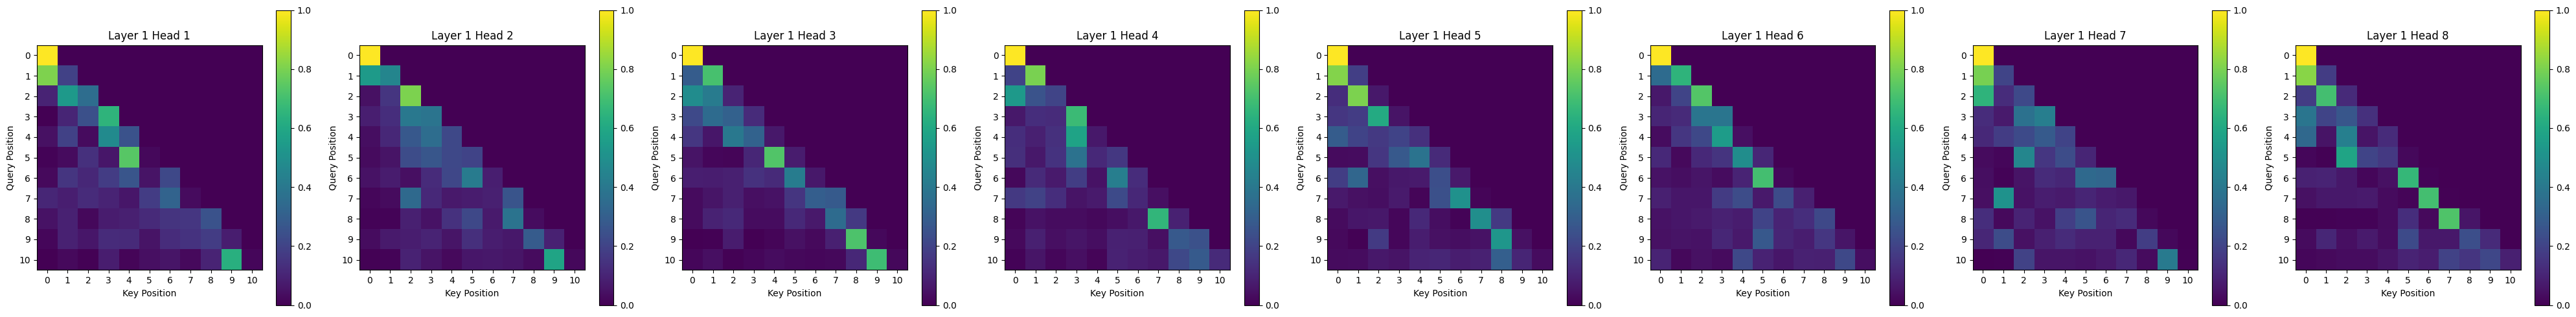

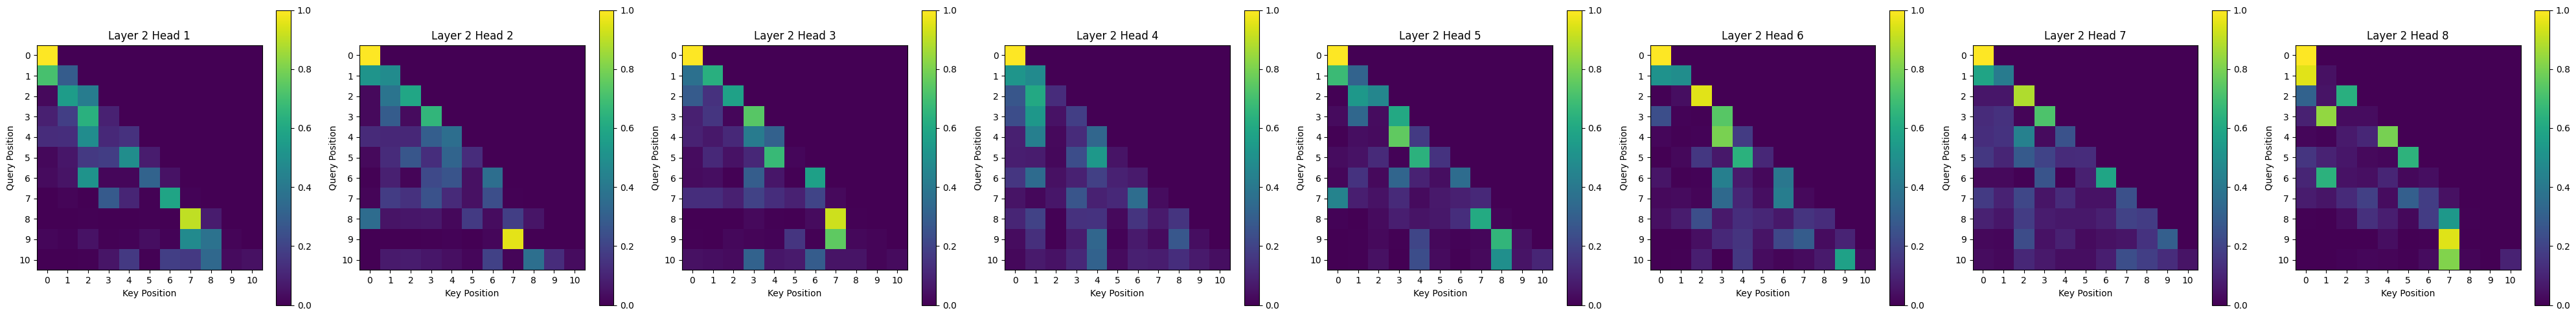

In [97]:
prompt = "How is your"
visualize_attention(model, prompt)

## MoE Model Visualization

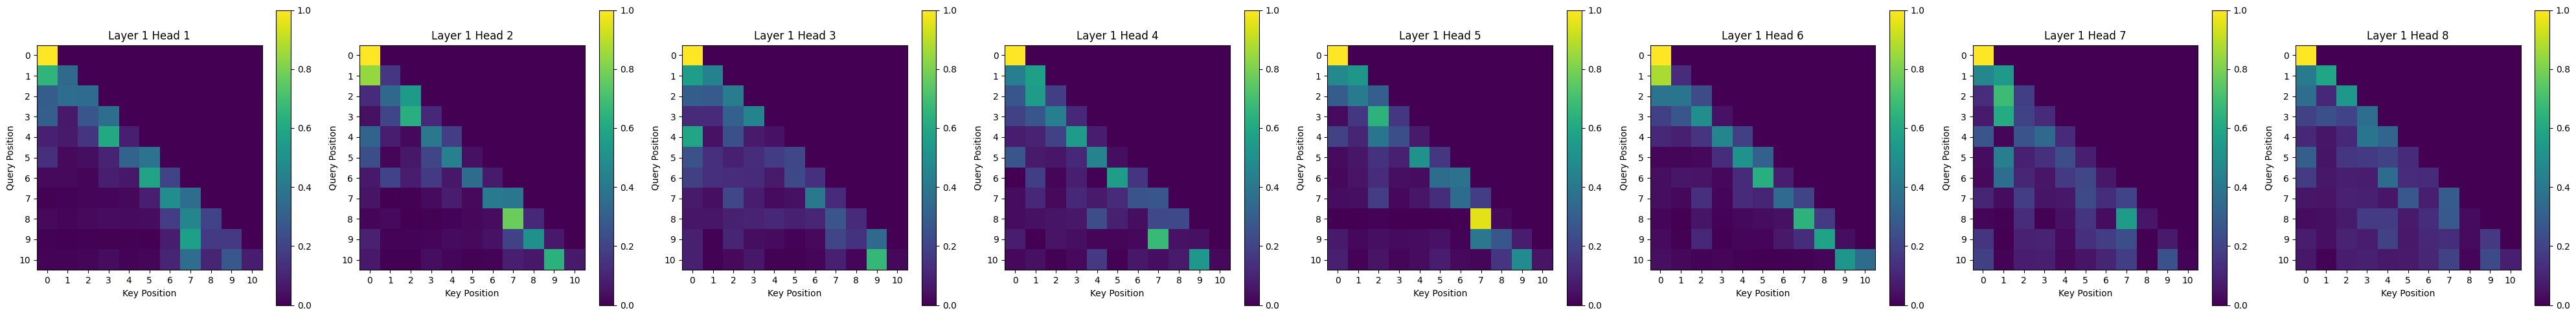

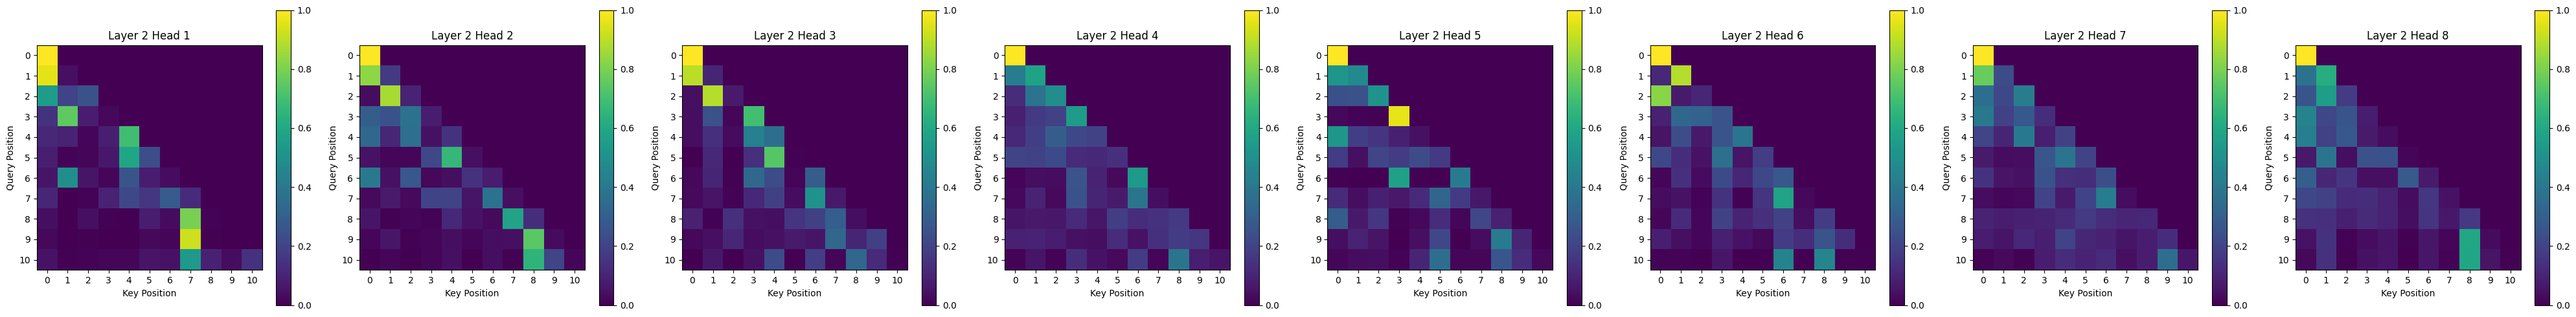

In [98]:
prompt = "How is your"
visualize_attention(model_moe, prompt)

## Definición: MoE + Greedy decoding, Temperature and top_K/top_p

In [ ]:
# TODO Implement Greedy decoding, Temperature and top_k/top_p

import torch.nn.functional as F

@torch.no_grad()
def generate_V3(
    prompt: str,
    max_new_tokens: int = 100,
    use_cache: bool = True,
    strategy: str = 'temperature', # 'greedy', 'temperature', 'top-k', 'top-p'
    temperature: float = 1.0,
    top_k: int = None,
    top_p: float = None
):
    """
    Genera texto a partir de un prompt inicial utilizando diferentes estrategias de muestreo.

    Args:
        prompt (str): El texto inicial para comenzar la generación.
        max_new_tokens (int): El número máximo de nuevos tokens a generar.
        use_cache (bool): Si se debe usar el caché KV para acelerar la inferencia.
        strategy (str): La estrategia de muestreo a utilizar. Opciones:
                        'greedy': Selecciona el token con la probabilidad más alta.
                        'temperature': Muestreo con ajuste de temperatura.
                        'top-k': Muestreo de los k tokens más probables.
                        'top-p': Muestreo de los tokens dentro de una masa de probabilidad 'p'.
        temperature (float): Factor de temperatura para el muestreo. Solo relevante para 'temperature', 'top-k', 'top-p'.
                             Valores > 1.0 hacen el muestreo más aleatorio.
                             Valores < 1.0 hacen el muestreo más determinista.
        top_k (int): Número de tokens a considerar para el muestreo Top-K. Solo relevante para 'top-k'.
                     Debe ser un entero positivo.
        top_p (float): Masa de probabilidad acumulada para el muestreo Top-P. Solo relevante para 'top-p'.
                       Debe ser un valor entre 0.0 y 1.0.
    """
    model_moe.eval() # Asegura que el modelo esté en modo evaluación (desactiva dropout, etc.)
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    kv_cache = None

    for _ in range(max_new_tokens):
        # Preparar la entrada para el modelo, usando el último token si hay caché
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:] # Solo el último token para la siguiente predicción
        else:
            # Si no hay caché o es la primera iteración, usar el bloque completo
            idx_cond = idx[:, -config.block_size:]

        # Realizar una pasada hacia adelante a través del modelo
        out = model_moe(idx_cond, kv_cache=kv_cache) if use_cache else model_moe(idx_cond)

        # Desempaquetar la salida: logits y (opcionalmente) el nuevo caché KV
        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None

        # Obtener los logits del último token predicho
        logits = logits[:, -1, :] # logit para el último token en la secuencia

        # Aplicar temperatura si es diferente de 1.0
        if temperature != 1.0 and temperature != 0:
            logits = logits / temperature

        # Aplicar el muestreo según la estrategia
        if strategy == 'greedy':
            next_token = torch.argmax(logits, dim=-1, keepdim=True)
        elif strategy == 'temperature':
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
        elif strategy == 'top-k':
            if top_k is None or top_k <= 0:
                raise ValueError("top_k debe ser un entero positivo para la estrategia 'top-k'.")

            # Filtrar los k valores más grandes
            v, i = torch.topk(logits, min(top_k, logits.size(-1)))
            out = logits.clone().fill_(-float('inf')) # Copia y rellena con -inf
            out.scatter_(1, i, v) # Vuelve a colocar los valores top-k
            probs = F.softmax(out, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
        elif strategy == 'top-p':
            if top_p is None or not (0.0 < top_p <= 1.0):
                raise ValueError("top_p debe ser un float entre 0.0 y 1.0 para la estrategia 'top-p'.")

            sorted_logits, sorted_indices = torch.sort(logits, descending=True)
            cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

            # Remover tokens cuya probabilidad acumulada excede top_p
            # Considerar también el token actual para no eliminarlo
            sorted_indices_to_remove = cumulative_probs > top_p
            # Retroceder un paso para incluir el último token que contribuyó a 'top_p'
            sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
            sorted_indices_to_remove[..., 0] = False # Asegurar que al menos el primer token no se elimine

            indices_to_remove = sorted_indices[sorted_indices_to_remove]
            logits[:, indices_to_remove] = -float('inf') # Establecer sus logits a -inf

            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
        else:
            raise ValueError(f"Estrategia de muestreo no reconocida: {strategy}")

        # Añadir el token generado a la secuencia
        idx = torch.cat((idx, next_token), dim=1)

    return decode(idx[0].tolist())


### PRUEBAS COMPARATIVAS ENTRE MODELOS Simple/MoE CON DISTINTOS PARAMETROS:

In [95]:
Text_ = "How is your"

# Lista de configuraciones a probar
param_grid = [
    {"strategy": "greedy", "temperature": 0.7, "top_k": None, "top_p": None},
    {"strategy": "greedy", "temperature": 1.0, "top_k": None, "top_p": None},
    {"strategy": "greedy", "temperature": 1.3, "top_k": None, "top_p": None},
    {"strategy": "temperature", "temperature": 0.7, "top_k": None, "top_p": None},
    {"strategy": "temperature", "temperature": 1.0, "top_k": None, "top_p": None},
    {"strategy": "temperature", "temperature": 1.3, "top_k": None, "top_p": None},
    {"strategy": "top-k", "temperature": 1.0, "top_k": 3, "top_p": None},
    {"strategy": "top-k", "temperature": 1.0, "top_k": 5, "top_p": None},
    {"strategy": "top-k", "temperature": 1.0, "top_k": 9, "top_p": None},
    {"strategy": "top-p", "temperature": 1.0, "top_k": None, "top_p": 0.3},
    {"strategy": "top-p", "temperature": 1.0, "top_k": None, "top_p": 0.6},
    {"strategy": "top-p", "temperature": 1.0, "top_k": None, "top_p": 0.9},
]

# Loop de experimentación
for i, params in enumerate(param_grid, 1):
    print(f"\n========== EXPERIMENTO {i} ==========")
    print(f"Params: {params}")

    # Generación con el modelo base SIMPLE (SIN MOE) y los parametros actuales
    result_2 = generate_V2(
        Text_,
        max_new_tokens=100,
        use_cache=True,
        strategy=params["strategy"],
        temperature=params["temperature"],
        top_k=params["top_k"],
        top_p=params["top_p"]
    )

    # Generación con generate_V3 que implementa MOE y los parámetros actuales
    result_3 = generate_V3(
        Text_,
        max_new_tokens=100,
        use_cache=True,
        strategy=params["strategy"],
        temperature=params["temperature"],
        top_k=params["top_k"],
        top_p=params["top_p"]
    )

    print("\nGenerateV2:", result_2)
    print("\nGenerateV3:", result_3)


========== EXPERIMENTO 1 ==========
Params: {'strategy': 'greedy', 'temperature': 0.7, 'top_k': None, 'top_p': None}

GenerateV2: How is your the the the the the the the the the the the the the the the the the the the the the the the the the

GenerateV3: How is your the the the the the the the the the the the the the the the the the the the the the the the the the

========== EXPERIMENTO 2 ==========
Params: {'strategy': 'greedy', 'temperature': 1.0, 'top_k': None, 'top_p': None}

GenerateV2: How is your the the the the the the the the the the the the the the the the the the the the the the the the the

GenerateV3: How is your the the the the the the the the the the the the the the the the the the the the the the the the the

========== EXPERIMENTO 3 ==========
Params: {'strategy': 'greedy', 'temperature': 1.3, 'top_k': None, 'top_p': None}

GenerateV2: How is your the the the the the the the the the the the the the the the the the the the the the the the the the

GenerateV3: How is y

## Conclusiones

### Comparación Generate_V2 vs Generate_V3 (Con MOE):

### Greedy (Experimentos 1–3)

V2 y V3: ambos caen en bucles de repetición (the the the…).

Conclusión: el comportamiento es prácticamente idéntico → el greedy search sin restricciones provoca colapso repetitivo en ambas versiones.

No existen diferencias entre versiones apreciables.

### Temperature sampling (Experimentos 4–6)

V2: genera frases más caóticas, con errores ortográficos pero cierta variedad.

V3: mantiene el caos, pero tiende a introducir algo de estructura.

Conclusión: V3 parece tener un sesgo hacia estructuras más coherentes/contextuales, aunque no correctas.

### Top-k (Experimentos 7–9)

V2: mantiene repeticiones ("the the the…"), con frases menos cohesionadas.

V3: produce texto con flujo más narrativo, aunque con alucinaciones de palabras.

Ej: V3 en Exp.9 introduce algunas frases con cierto sentido.

Conclusión: V3 explora más creativamente el espacio que V2, menos repeticiones, aunque ambas pierden coherencia semántica.

### Top-p (Experimentos 10–12)

V2: se queda en redundancia ("the the the…"), aunque un poco más variado que greedy.

V3: genera salidas más largas y articuladas, aunque con muchos errores.

Exp.12 es un buen ejemplo: V2 genera incoherencia, V3 arma frases con cierta cadencia.

Conclusión: V3 (Modelo MoE) pareciera funcionar algo mejor mostrando mayor diversidad y cierto ritmo con pseudo-coherencia, pero carente de sentido.

## Conclusiones generales

Al pasar de 4 a 8 Multi-heads, corpus de 120.000 caracteres (+20%) y de 5 a 20 epochs se aprecia cierta mejora semantica y sintáctica, aunque lejos del rendimiento pretendido.

En modo greedy, ambas versiones probadas fallan igual (colapso repetitivo).

## Diferencias clave:

V2 → Es más caótico y fragmentado, con mas repeticiones.

V3 → Tiende a generar salidas con cierta estructura aunque en general incorrectas.

Mejor rendimiento relativo:

V3 se comporta mejor en top-k / top-p, mostrando creatividad y menos loops.

V2 se queda más limitado en ese sentido.


# Congratulations! 🎉

After completing the tasks you've successfully pretrained for first GPT, remember to add your conclusions and findings! And you can now brag to your friend on how LLMs and GPTs work!

